# Titanic: Machine Learning from Disaster

The goal of this notebook is for participation in the [kaggle compettion](https://www.kaggle.com/c/titanic#evaluation) for binary classification of whether a passenger survises or not.

***Further ideas***
A couple of further ideas - all related with feature engineering. As I am still a student of the ways in Machine Learning additional.
1. New Feature: Common cabins will likely impact the survivability.
2. New Feature: A flag of whether the person is alone or not. [done]
3. New Feature: Child or not - the likelihood of having parents will increase the survivability.

... any new ideas will be added here.

***P.S.***
[Thanks to this excellent kernel](https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic) I have more ideas.

### Loading the data

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
import warnings; warnings.simplefilter('ignore') # ignore warnings

In [2]:
train_df = pd.read_csv('./datasets/Titanic_Data/train.csv')
test_df = pd.read_csv('./datasets/Titanic_Data/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df[train_df['Ticket'] == '113803']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
137,138,0,1,"Futrelle, Mr. Jacques Heath",male,37.0,1,0,113803,53.1,C123,S


## Exploratory Data Analysis

There is a lot of ground to cover here, but we will start with the simplest things:
1. Getting the summary of the data set.
2. Correlation Plot - naturally we will exclude the PassengerId, as it does not have any information regarding its survived status.
3. Analysis of the missing data - how it could be handled.

### 1. Summary

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 2. Dealing with missing values
In order to display missing values a third-party package will be used - missingno

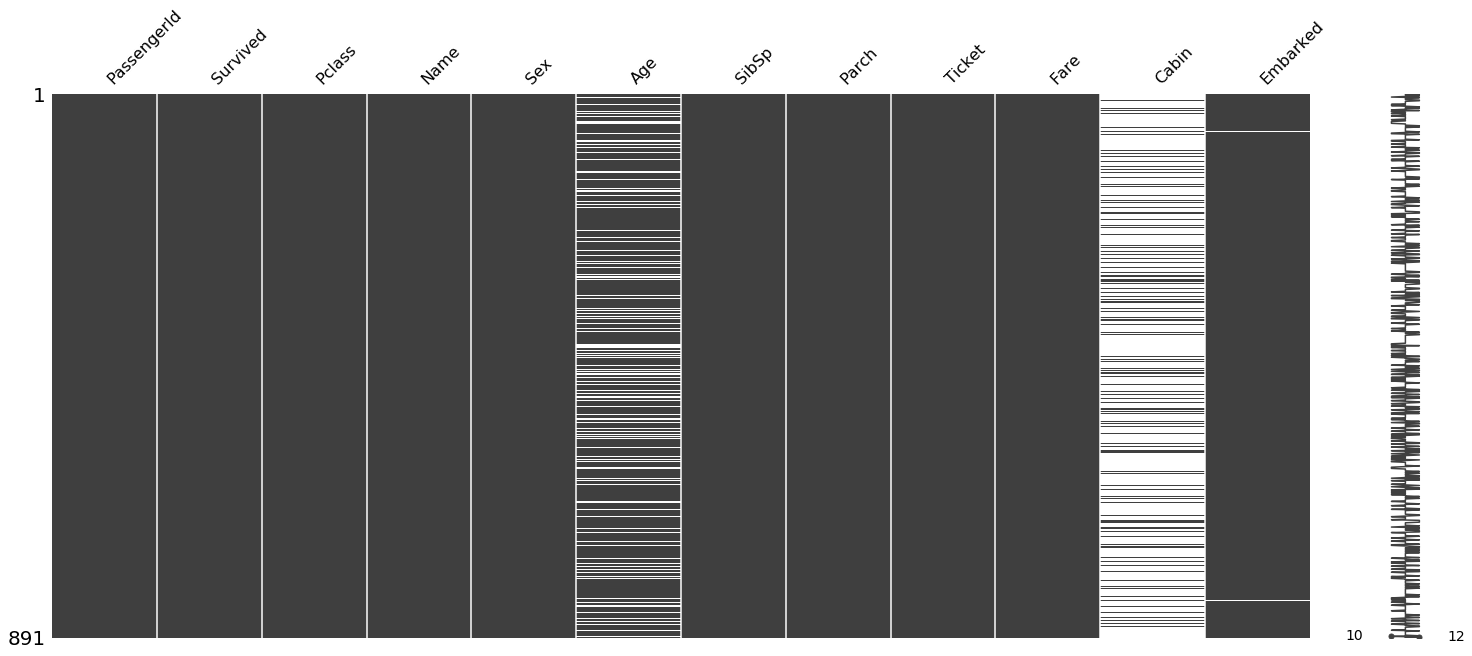

In [7]:
import missingno as msno
msno.matrix(train_df)

#### Dealing with age

In [8]:
pclass1_mean_age = train_df[train_df['Pclass'] == 1]['Age'].mean()
pclass2_mean_age = train_df[train_df['Pclass'] == 2]['Age'].mean()
pclass3_mean_age = train_df[train_df['Pclass'] == 3]['Age'].mean()
pclass1_mean_age, pclass2_mean_age, pclass3_mean_age

(38.233440860215055, 29.87763005780347, 25.14061971830986)

In [67]:
for index, row in train_df.iterrows():
    if np.isnan(row['Age']):
        if row['Pclass'] == 1:
            train_df.loc[index, 'Age'] = pclass1_mean_age
        elif row['Pclass'] == 2:
            train_df.loc[index, 'Age'] = pclass2_mean_age
        elif row['Pclass'] == 3:
            train_df.loc[index, 'Age'] = pclass3_mean_age
        else:
            print('Exception')

The rationale is that we assign the mean age for each class to the missing value, since the mean ages for each classes go down with class, hence the survivability.

#### Dealing with Embarked
It might be innacurate, but let us assign the most common value of the Embarked to the missing values.

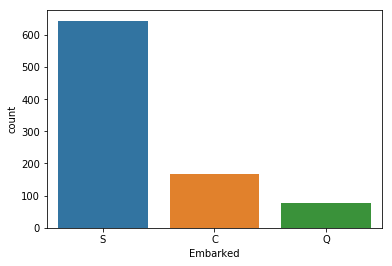

In [10]:
sns.countplot(x="Embarked",  data=train_df)
plt.show()

As we can see here the most common **Embarked** value is **S**outhampton.

In [11]:
train_df.loc[train_df['Embarked'].isnull(),'Embarked'] = 'S'

#### Dealing with Cabin
I am going to ignore this feature for now.

### 3. Feature Engineering.
Let us go, feature by feature, to see what is their relation to the outcome.

#### Pclass vs Survived

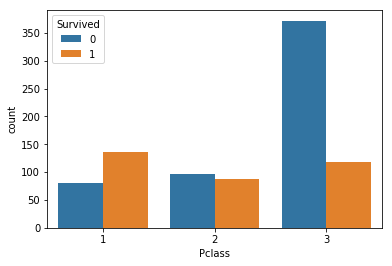

In [12]:
sns.countplot(x="Pclass", hue="Survived", data=train_df)
plt.show()

As expected the people in the third class had the highest mortallity rate.

#### Sex vs Survived

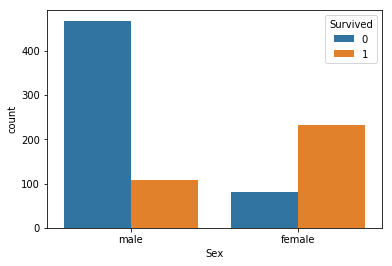

In [13]:
sns.countplot(x="Sex", hue="Survived", data=train_df)
plt.show()

Again, nothing surprising, as probably in the rescue operation women and children are with priority.

#### Age vs Survived

Here is an interesting one - since age is a continious variable, a more understandable approach would be to split them into age categories. Let the categories be by tens. One could argue that there is a more optimal variant of the split, but this is just a general split and the idea is to split them into groups to distinguish children, teenagers, young adults and so on.

##### New Feature: Age Class

In [14]:
train_df['AgeClass'] = pd.cut(train_df['Age'], 8, labels=[1,2,3,4,5,6,7,8])

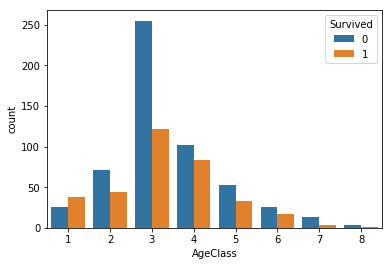

In [15]:
sns.countplot(x="AgeClass", hue="Survived", data=train_df)
plt.show()

The results are not really suprising, but you can clearly see that if you are between the ages of 30 and 40, your chances are not good.

#### Family Size and Survival
Since the data set lists the number of the siblings and parents, we can combine it into a super-feature **FamilySize** that has the total amount of people related to the person.

##### New Feature: Family Size

In [16]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

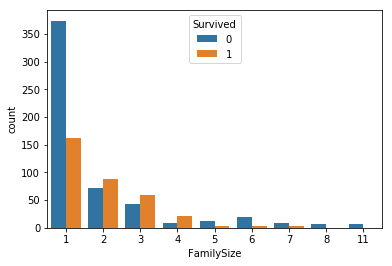

In [17]:
sns.countplot(x="FamilySize", hue="Survived", data=train_df)
plt.show()

It seems that being alone does not amount to much. Let's create another flag, which will tell us if a person is alone or not.
##### New Feature: isAlone

In [18]:
# 0 - person is not alone, 1 is alone
train_df['isAlone'] = np.where(train_df['FamilySize'] > 1, 0, 1)

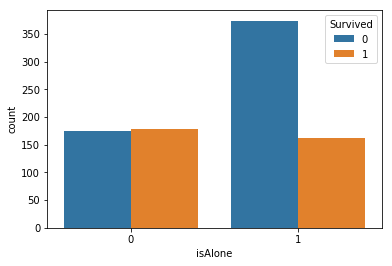

In [19]:
sns.countplot(x="isAlone", hue="Survived", data=train_df)
plt.show()

Wow... puts the chart above in a different perspective - people with family members on board are more likely to survive.

#### Fare

Same like age, categorizing it makes more sense. Looking at the fare distribution plot it makes more sense to categorize everything above a certain fare as one group and devide the others.

In [20]:
train_df['FareClass'] = 0

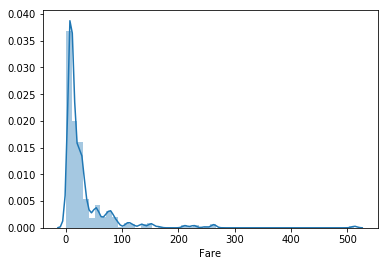

In [21]:
sns.distplot(train_df['Fare'])
plt.show()

Looking at the fare distribution suggests we can treat people people, who paid more than 100 as a group.

In [22]:
# a bit of a manual job but hey...
train_df.loc[train_df['Fare'] > 100, 'FareClass'] = 1

In [23]:
# If I wasn't lazy to do just a for loop or smth.
train_df.loc[(train_df['Fare'] < 100) & (train_df['Fare'] >= 80), 'FareClass'] = 2
train_df.loc[(train_df['Fare'] < 80) & (train_df['Fare'] >= 60), 'FareClass'] = 3
train_df.loc[(train_df['Fare'] < 60) & (train_df['Fare'] >= 40), 'FareClass'] = 4
train_df.loc[(train_df['Fare'] < 40) & (train_df['Fare'] >= 20), 'FareClass'] = 5
train_df.loc[(train_df['Fare'] < 20) & (train_df['Fare'] >= 0), 'FareClass'] = 6

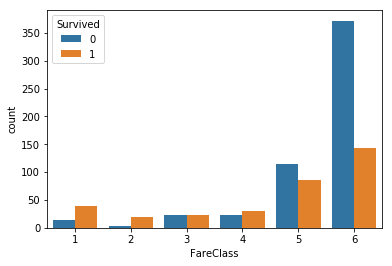

In [24]:
sns.countplot(x="FareClass", hue="Survived", data=train_df)
plt.show()

Now it is clear - them more you payed, the more likely are you to survive, although this relationship is not as straight forward, as people who payed betwen 60 and 80 have an equal chance of Surviving or not, the people in the lower *FareClass* have a greater survival chance.

#### Embarked vs Survival

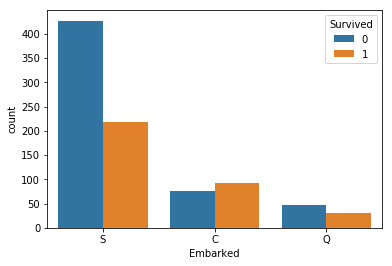

In [25]:
sns.countplot(x="Embarked", hue="Survived", data=train_df)
plt.show()

The relationship between the embark location and survival is probably related to the fact that different classes boarded from different places. 

### 4. Correlation Plot

First let's encode the categoricals into actual values.

In [72]:
train_df['Embarked_encoded'] = train_df['Embarked'].astype('category').cat.codes
train_df['Sex_encoded'] = train_df['Sex'].astype('category').cat.codes
train_df['AgeClass'] = train_df['AgeClass'].astype('int')
train_adj_df = train_df[['Survived','Pclass','AgeClass','FamilySize','isAlone','FareClass','Sex_encoded','Embarked_encoded','Age','Fare']].copy()
train_adj_df.head()

,Survived,Pclass,AgeClass,FamilySize,isAlone,FareClass,Sex_encoded,Embarked_encoded,Age,Fare
0,0,3,3,2,0,6,1,2,22.0,7.2500
1,1,1,4,2,0,3,0,0,38.0,71.2833
2,1,3,3,1,1,6,0,2,26.0,7.9250
3,1,1,4,2,0,4,0,2,35.0,53.1000
4,0,3,4,1,1,6,1,2,35.0,8.0500


In [73]:
train_adj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived            891 non-null int64
Pclass              891 non-null int64
AgeClass            891 non-null int64
FamilySize          891 non-null int64
isAlone             891 non-null int64
FareClass           891 non-null int64
Sex_encoded         891 non-null int8
Embarked_encoded    891 non-null int8
Age                 891 non-null float64
Fare                891 non-null float64
dtypes: float64(2), int64(6), int8(2)
memory usage: 57.5 KB


In [74]:
cormat = train_adj_df.corr()
cormat

,Survived,Pclass,AgeClass,FamilySize,isAlone,FareClass,Sex_encoded,Embarked_encoded,Age,Fare
Survived,1.000000,-0.338481,-0.046917,0.016639,-0.203367,-0.298456,-0.543351,-0.167675,-0.050504,0.257307
Pclass,-0.338481,1.000000,-0.379550,0.065997,0.135207,0.687930,0.131900,0.162098,-0.403858,-0.549500
AgeClass,-0.046917,-0.379550,1.000000,-0.239653,0.158742,-0.163377,0.080771,-0.009299,0.978469,0.117856
FamilySize,0.016639,0.065997,-0.239653,1.000000,-0.690922,-0.300527,-0.200988,0.066516,-0.254217,0.217138
isAlone,-0.203367,0.135207,0.158742,-0.690922,1.000000,0.379225,0.303646,0.063532,0.170877,-0.271832
FareClass,-0.298456,0.687930,-0.163377,-0.300527,0.379225,1.000000,0.228166,0.221433,-0.169756,-0.842204
Sex_encoded,-0.543351,0.131900,0.080771,-0.200988,0.303646,0.228166,1.000000,0.108262,0.080464,-0.182333
Embarked_encoded,-0.167675,0.162098,-0.009299,0.066516,0.063532,0.221433,0.108262,1.000000,-0.016622,-0.224719
Age,-0.050504,-0.403858,0.978469,-0.254217,0.170877,-0.169756,0.080464,-0.016622,1.000000,0.120886
Fare,0.257307,-0.549500,0.117856,0.217138,-0.271832,-0.842204,-0.182333,-0.224719,0.120886,1.000000


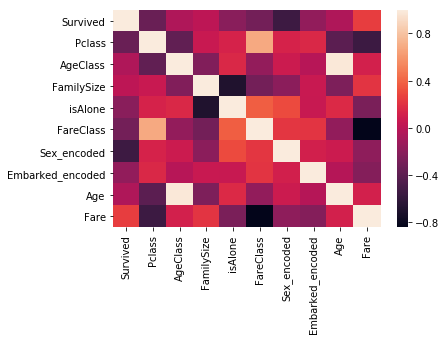

In [75]:
sns.heatmap(cormat, 
            xticklabels=cormat.columns.values,
            yticklabels=cormat.columns.values)
plt.show()

Looking at the correlation plot it seems that the highest correlation is exhibited by **Sex** and **Pclass**, which makes sense as being a female and in 1st class the chance of survival is higher.

### 5. Train Test Split

In [76]:
from sklearn.model_selection import train_test_split

X, y = train_adj_df.loc[:,['Pclass','AgeClass','FamilySize','isAlone','FareClass','Sex_encoded','Embarked_encoded','Age','Fare']].values, train_adj_df.loc[:,['Survived']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 9), (268, 9), (623, 1), (268, 1))

## Method 1: Simple Logistic Regression

In [77]:
import statsmodels.api as sm

### Fitting the model.

In [78]:
logit_model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.451570
         Iterations 7


In [79]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  623
Model:                          Logit   Df Residuals:                      614
Method:                           MLE   Df Model:                            8
Date:                Tue, 13 Nov 2018   Pseudo R-squ.:                  0.3240
Time:                        22:41:13   Log-Likelihood:                -281.33
converged:                       True   LL-Null:                       -416.19
                                        LLR p-value:                 1.122e-53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1825      0.200     -5.913      0.000      -1.574      -0.791
x2             0.7609      0.390      1.949      0.051      -0.004       1.526
x3            -0.2852      0.118     -2.427      0.015      -0.516      -0.055
x4            -0.6565      0.327     -2.005      0.045      -1.298      -0.015
x5             0.9108      0.130      7.016      0.000       0.656       1.165
x6            -2.6637      0.236    -11.266      0.000      -3.127      -2.200
x7            -0.1716      0.140     -1.222      0.222      -0.447       0.104
x8            -0.1027      0.040     -2.580      0.010      -0.181      -0.025
x9             0.0262      0.004      6.344      0.000       0.018       0.034
==============================================================================
"""

### Getting the predictions and evaluating accuracy.

In [80]:
y_hat = logit_model.predict(X_test)
y_hat = (y_hat > 0.5).astype(int)
y_hat = y_hat.reshape(-1,1) # getting into the right shape

In [81]:
accuracy = float((y_hat == y_test).astype(int).sum())/float(len(y_test))
accuracy

0.7947761194029851

From the results we got it seems that the model can predict whether the passenger will survive with a 77% accuracy. This is when it includes all of the features.

### What if we regularize?

In [82]:
logit_model_reg = sm.Logit(y_train, X_train).fit_regularized(alpha=1, disp=False)
logit_model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  623
Model:                          Logit   Df Residuals:                      614
Method:                           MLE   Df Model:                            8
Date:                Tue, 13 Nov 2018   Pseudo R-squ.:                  0.3233
Time:                        22:41:29   Log-Likelihood:                -281.62
converged:                       True   LL-Null:                       -416.19
                                        LLR p-value:                 1.498e-53
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1128      0.197     -5.663      0.000      -1.498      -0.728
x2             0.5836      0.384      1.518      0.129      -0.170       1.337
x3            -0.2458      0.112     -2.194      0.028      -0.465      -0.026
x4            -0.5287      0.320     -1.652      0.099      -1.156       0.099
x5             0.8504      0.126      6.748      0.000       0.603       1.097
x6            -2.5810      0.232    -11.129      0.000      -3.036      -2.126
x7            -0.1500      0.139     -1.082      0.279      -0.422       0.122
x8            -0.0839      0.039     -2.145      0.032      -0.161      -0.007
x9             0.0253      0.004      6.232      0.000       0.017       0.033
==============================================================================
"""

In [83]:
yreg_hat = logit_model_reg.predict(X_test)
yreg_hat = (yreg_hat > 0.5).astype(int)
yreg_hat = yreg_hat.reshape(-1,1)
accuracy_reg = float((yreg_hat == y_test).astype(int).sum())/float(len(y_test))
accuracy_reg

0.7985074626865671

A little better - with 78%.

### Summary:
It seems that Logistic Regression is only able to go as far up to almost 78%, with or without regularization. 

Ideas for future work: Feature removal or addition.

## Method 2: Decision Tree

In [87]:
from sklearn import tree
y_ = y.reshape(y.shape[0],) # fixing the vector so it fits

feature_names = ['Pclass','AgeClass','FamilySize','isAlone','FareClass','Sex_encoded','Embarked_encoded','Age','Fare']

In [88]:
# Making the classificer
dt_clf = tree.DecisionTreeClassifier()
dt_clf = dt_clf.fit(X,y_)

Before we predict and get the accuracy, lets visualize it.

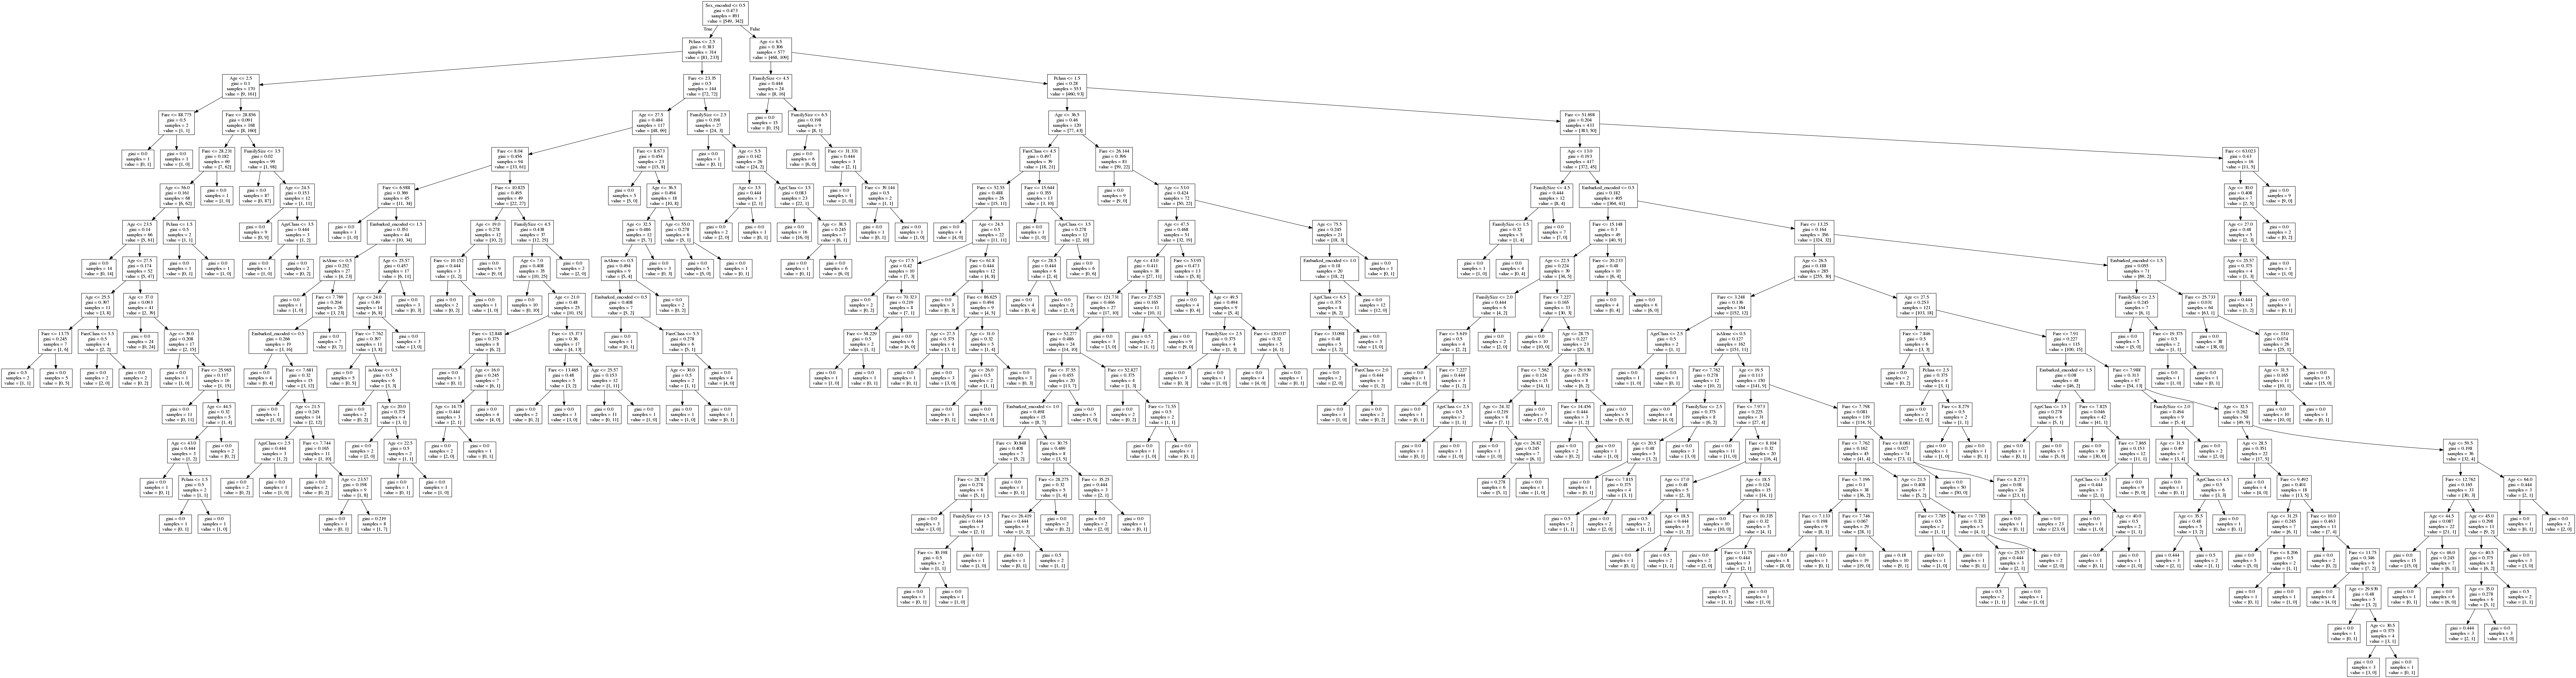

In [89]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO()  
tree.export_graphviz(dt_clf, out_file=dot_data,  
                         feature_names=feature_names)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

In [90]:
y_hat_dt = dt_clf.predict(X_test)
y_hat_dt = (y_hat_dt > 0.5).astype(int)
y_hat_dt = y_hat_dt.reshape(-1,1)
accuracy_dt = float((y_hat_dt == y_test).astype(int).sum())/float(len(y_test))
accuracy_dt

0.9888059701492538

It's too good to be true... Since the Train and the Test were taken from the actual Train dataset it had overfit.. badly. Let's try with cross validation.

In [91]:
score_dt = cross_val_score(dt_clf, X, y_, cv=5)
score_dt.mean()

0.7822770656081469

Yes, that makes more sense. 

Alright, since we didn't achieve a better result, lets jump onto the whole forest.

## Method 3: Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# fixing the y
y_ = y.reshape(y.shape[0],)

classifier_rf = RandomForestClassifier(n_estimators = 1000, max_features='sqrt', criterion = 'entropy', random_state = 0)
scores_rf = cross_val_score(classifier_rf, X, y_, cv=5)
scores_rf.mean()

0.820492859921689

Way better than a simple tree.

## Method 4: SVM

In [93]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# fixing the y
y_ = y.reshape(y.shape[0],)
classifier_svc = SVC(kernel = 'rbf', random_state = 0)
scores_svc = cross_val_score(classifier_svc, X, y_, cv=5)
scores_svc.mean()

0.6903799116741796

Poor svm...

## Method 5: XGBoost?!

In [94]:
import xgboost as xgb

In [95]:
# reshaping y_train, test - the xgb classifier doesn't like (,1) vectors
y_train_ = y_train.reshape(y_train.shape[0],)
y_test_ = y_test.reshape(y_test.shape[0],)

In [96]:
# train
xgbclf = xgb.XGBClassifier()
xgbclf.fit(X_train, y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [97]:
# test + score
xgbclf.score(X_test, y_test_)

0.832089552238806

Very close to the SVM result... Let's see if we can optimize the result.
#### *Optimization of XGBOOST*
Planning to use grid-search on the parameters.

In [98]:
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid
xgb_param_grid = {
    'n_estimators': range(50, 501, 10),
    'max_depth': range(2, 15),
    'learning_rate': [0.05, 0.1, 0.3, 0.4, 0.5, 0.6]
}

# Creating the initial regressor
xgbclf_ = xgb.XGBClassifier(n_estimators=10)

In [99]:
xgb_gridsearch = RandomizedSearchCV(param_distributions = xgb_param_grid,
                                   estimator = xgbclf_, scoring = 'accuracy',
                                   verbose = 1, n_iter = 50, cv = 4)

In [100]:
xgb_gridsearch.fit(X, y_)

print('Best parameters ', xgb_gridsearch.best_params_)
print('Best accuracy: ', xgb_gridsearch.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters  {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Best accuracy:  0.8428731762065096


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.6s finished


XGBoost improved the score by 1%. Lets try to submit this.

## Submission

### 1. Missing Data

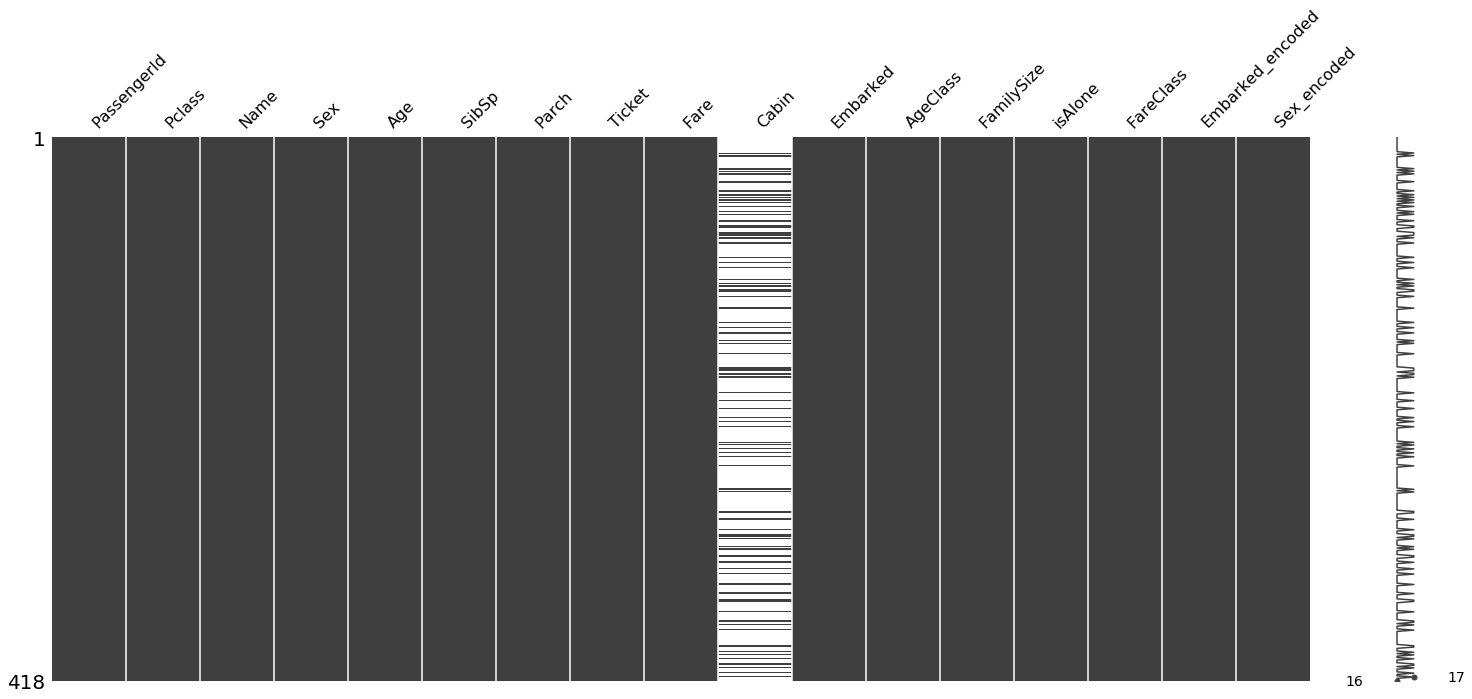

In [102]:
# Checking for missing data
msno.matrix(test_df)

In [103]:
# Dealing with the missing values, same as in the training data set.
pclass1t_mean_age = test_df[test_df['Pclass'] == 1]['Age'].mean()
pclass2t_mean_age = test_df[test_df['Pclass'] == 2]['Age'].mean()
pclass3t_mean_age = test_df[test_df['Pclass'] == 3]['Age'].mean()
pclass1t_mean_age, pclass2t_mean_age, pclass3t_mean_age

(40.69253240880313, 28.83664677730126, 24.395434035405092)

In [104]:
for index, row in test_df.iterrows():
    if np.isnan(row['Age']):
        if row['Pclass'] == 1:
            test_df.loc[index, 'Age'] = pclass1_mean_age
        elif row['Pclass'] == 2:
            test_df.loc[index, 'Age'] = pclass2_mean_age
        elif row['Pclass'] == 3:
            test_df.loc[index, 'Age'] = pclass3_mean_age
        else:
            print('Exception')

In [105]:
# For the fare we will use the ismple fillna
mean_fare = test_df['Fare'].mean()
test_df.loc[test_df['Fare'].isnull(),'Fare'] = mean_fare

In [106]:
# Dealing with Embarked
test_df.loc[test_df['Embarked'].isnull(),'Embarked'] = 'S'

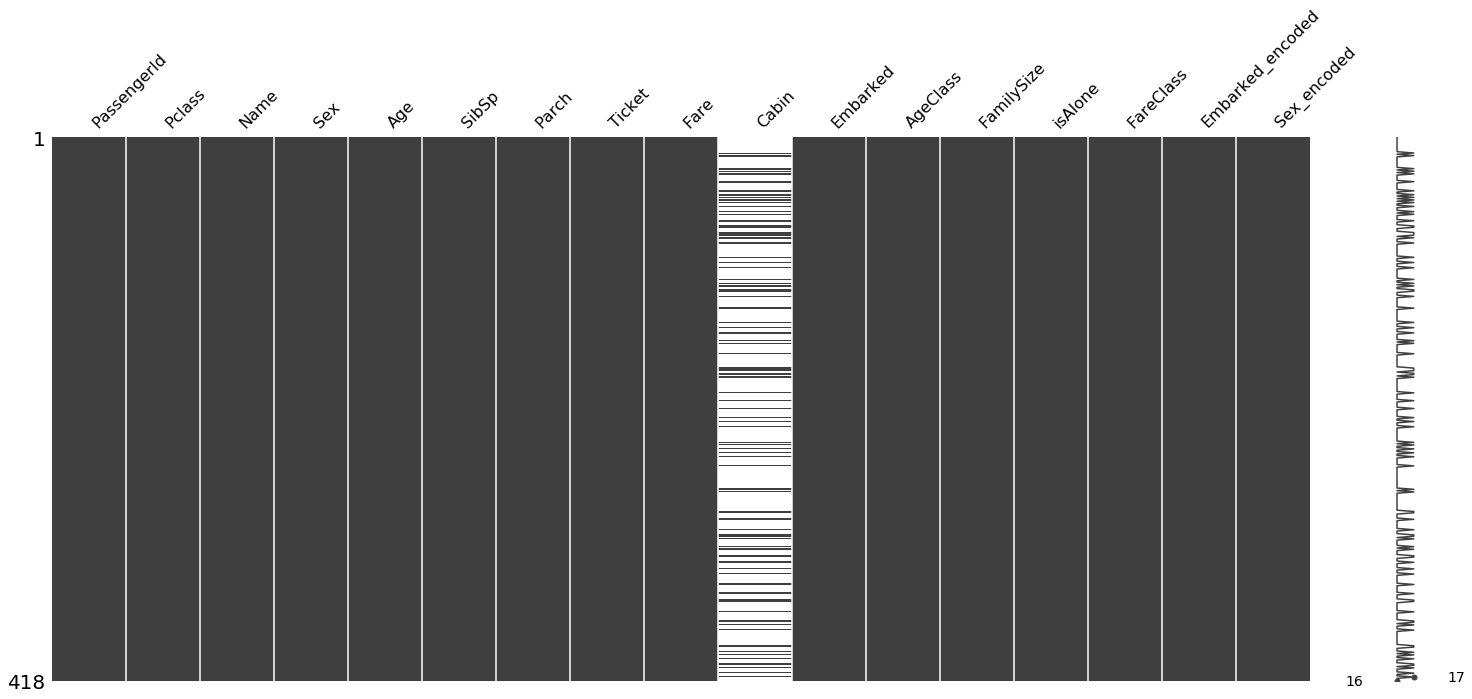

In [107]:
# Double Check
msno.matrix(test_df)

### 2. Features

#### New features

In [108]:
# I should make a function... shouldn't I?
test_df['AgeClass'] = pd.cut(test_df['Age'], 8, labels=[1,2,3,4,5,6,7,8])
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['isAlone'] = np.where(test_df['FamilySize'] > 1, 0, 1)
# Dealing with fares
test_df['FareClass'] = 0
test_df.loc[(test_df['Fare'] < 100) & (test_df['Fare'] >= 80), 'FareClass'] = 2
test_df.loc[(test_df['Fare'] < 80) & (test_df['Fare'] >= 60), 'FareClass'] = 3
test_df.loc[(test_df['Fare'] < 60) & (test_df['Fare'] >= 40), 'FareClass'] = 4
test_df.loc[(test_df['Fare'] < 40) & (test_df['Fare'] >= 20), 'FareClass'] = 5
test_df.loc[(test_df['Fare'] < 20) & (test_df['Fare'] >= 0), 'FareClass'] = 6

#### Feature processing

In [109]:
test_df['Embarked_encoded'] = test_df['Embarked'].astype('category').cat.codes
test_df['Sex_encoded'] = test_df['Sex'].astype('category').cat.codes
test_df['AgeClass'] = test_df['AgeClass'].astype('int')
test_adj_df = test_df[['Pclass','AgeClass','FamilySize','isAlone','FareClass','Sex_encoded','Embarked_encoded','Age','Fare']].copy()

#### Predicting the new values - Old entry - SVM

In [117]:
# Predicting New Values
X_true_test = test_adj_df.loc[:,['Pclass','AgeClass','FamilySize','isAlone','FareClass','Sex_encoded','Embarked_encoded','Age','Fare']].values
# Training the Classifier
classifier_rf.fit(X, y)
# and now predict
predicted_survivals = classifier_rf.predict(X_true_test)
predicted_survivals_df = pd.DataFrame(data={'PassengerId':test_df['PassengerId'].values, 
                                           'Survived': predicted_survivals})


Predicting the new values - New Entry - XGBoost

In [119]:
# Predicting New Values
X_true_test = test_adj_df.loc[:,['Pclass','AgeClass','FamilySize','isAlone','FareClass','Sex_encoded','Embarked_encoded','Age','Fare']].values
xgb_preds = xgb_gridsearch.predict(X_true_test)

In [120]:
predicted_survivals_df = pd.DataFrame(data={'PassengerId':test_df['PassengerId'].values, 
                                           'Survived': xgb_preds})

In [121]:
# Make a CSV
predicted_survivals_df.to_csv('./submissions/titanic_pred__20181113_submission_5.csv', index=False)